# Analyzing Stock Market Data to Build a Portfolio

## Project Goal

### Analyze share price data from various listings to answer the following questions:

1. What kind of Growth % do we expect from the various listings? <br>
2. How do the Growth % of the different listings correlate to each other? <br>
3. What is the estimated listing share price at a future date (prediction)? <br>
4. What kind of volatility do the listings have? <br>
5. How can we use our analysis to form a balanced investment portfolio? <br>

### Overall Methodology:

1. Import and organize data for the various listings <br>
2. Make observations about the data <br>
3. Use these observations to answer the questions <br>

## References

Share price information obtained from: [Yahoo Finance](https://finance.yahoo.com/) <br>
Yahoo Finance library: [yfinance](https://pypi.org/project/yfinance/) <br>
Robinhood Stocks library: [robin_stocks](http://www.robin-stocks.com/en/latest/functions.html) <br>

## Inputs

### Below are the inputs to perform the analysis

In [1]:
#s_list='AM AAPL AMZN FB NVDA NFLX MSFT PYPL GOOGL TWTR TSLA ZNGA NCLH '  # List of "listings" to be analyzed
s_list='BTC-USD ETH DOGE-USD'
total_investment=2001  # Total investment value in USD
sample_interval ='1d'  # Time interval to fetch data at
#start='11/27/2020'  # Start date of interest
#start='09/26/2020'  # Start date of interest
start='30w'
end='03/06/2021'  # End date of interest
datetime_query=['05/28/2021'] # Datetime query values (for prediction)
pricetype='Close' # Open, Close, Low, High

## Import Libraries

In [2]:
# Python Version
import sys
sys.version

'3.6.12 | packaged by conda-forge | (default, Dec  9 2020, 00:36:02) \n[GCC 9.3.0]'

In [3]:
#Update python standard libraries install
!pip install --upgrade pip

# library to for array handling
import numpy as np 

# library for dataframes
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Linear Model
import sklearn as sk

# List Functions module
!pip install listfun
from listfun import Listoper as lst

# Math Module
import math

# Matplotlib and associated plotting modules
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import seaborn as sns

# Machine-Learning and analysis modules
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

! pip install expsolver;
from expsolver import Solver as solve

# Module to handle XML and HTML 
! pip install lxml;

#Finance information import (Link in "Yahoo Finance" Markdown Cell in the "References" Section)
!pip install yfinance;
import yfinance as yf;

#Robinhood stocks functions
!pip install robin_stocks;
import robin_stocks as r;

print('Libraries imported.')

Libraries imported.


## Import Data into DataFrame

In [4]:
end=pd.to_datetime(end)
if len(start)<=4:
    start=end-pd.to_timedelta(start)
else:
    start=pd.to_datetime(start)
print('Start: {}, End: {}'.format(start,end))

Start: 2020-08-08 00:00:00, End: 2021-03-06 00:00:00


### Create basic dataframe "df_info" containing all the available stocks information

In [5]:
# Create list of stock names as specified by the User
s_list=s_list.split(' ')

In [6]:
# Initialize Basic Dataframe as empty
df_info=pd.DataFrame() 

# Add Shares information for List of stock names
for item in s_list:
    data=yf.Ticker(item)
    df_data=data.history(period=sample_interval,start=start ,end=end )
    df_data=df_data.reset_index()
    df_data['Name']=pd.DataFrame([item for i in range(0,len(df_data))])
    df_info=pd.concat([df_info,df_data])
    

# Display basic information
df_info.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Name
0,2020-08-08,11604.553711,11800.064453,11558.431641,11754.045898,17572057837,0.0,0,BTC-USD
1,2020-08-09,11737.325195,11806.056641,11548.784180,11675.739258,17489608833,0.0,0,BTC-USD
2,2020-08-10,11662.256836,12045.140625,11662.256836,11878.111328,26114112569,0.0,0,BTC-USD
3,2020-08-11,11881.647461,11932.710938,11195.708984,11410.525391,27039782640,0.0,0,BTC-USD
4,2020-08-12,11404.596680,11748.396484,11249.605469,11584.934570,25064548486,0.0,0,BTC-USD


In [7]:
# Size of Data:
print('Size of the full dataset is: {} by {}'.format(df_info.shape[0],df_info.shape[1]))

Size of the full dataset is: 560 by 9


## Exploratory Pre-Processing Analysis

### Create Dataframe (df) of Relevant share Price vs. date, which will be the data looked at in this analysis  

In [8]:
# Create new Dataframe of relevant Share Prices
datevalues=df_info['Date'].sort_values().drop_duplicates().tolist()
df=pd.DataFrame(index=datevalues,columns=s_list)
for item in s_list:
    df_item=df_info[df_info['Name']==item]
    for ind in df.index.tolist():
    #df[['Date',item]]=df_info.loc[df_info['Name']==item,['Date',pricetype]]
        try:
            df.loc[ind,item]=df_item.loc[df_item['Date']==ind,pricetype].values[0]
        except:
            pass
    df[item].fillna(method='bfill',inplace=True)
    df[item].fillna(method='ffill',inplace=True)

df_price=df.copy()
# Display initial few contents of the Dataset
df.tail(10)

,BTC-USD,ETH,DOGE-USD
2021-02-25,47093.851562,25.110001,0.050167
2021-02-26,46339.761719,25.620001,0.050480
2021-02-27,46188.453125,26.139999,0.050083
2021-02-28,45137.769531,26.139999,0.048052
2021-03-01,49631.242188,26.139999,0.050599
2021-03-02,48378.988281,26.219999,0.050262
2021-03-03,50538.242188,25.959999,0.050592
2021-03-04,48561.167969,24.860001,0.050048
2021-03-05,48927.304688,25.459999,0.049609
2021-03-06,48912.382812,25.459999,0.050984


### Display basic information about this dataset

In [9]:
# Display basic statistics of the opening prices
# Darker cells denote higher values
df.describe().style.background_gradient(axis=1).format("{:.2f}")

,BTC-USD,ETH,DOGE-USD
count,211.00,211.00,211.00
mean,22831.83,18.48,0.01
std,13471.08,4.17,0.02
min,10131.52,12.58,0.00
25%,11563.72,14.26,0.00
50%,17804.01,17.90,0.00
75%,33060.06,22.19,0.01
max,57539.95,26.22,0.08


### Create basic Time plot to look at pertinent information

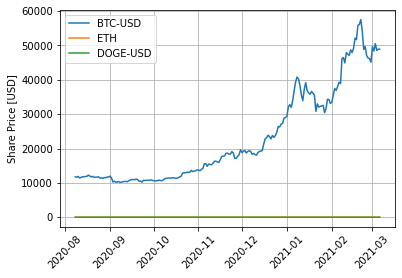

In [10]:
# Plot Open price vs. Time
ax= plt.subplot()
for item in df_price.columns:
    plt.plot(df_price[item])

plt.xticks(rotation=45)
ax.legend(df_price.columns)
plt.ylabel('Share Price [USD]')
ax.grid(True)

## What kind of Growth % do we see with the various listings?

### Normalize the opening price to determine Growth % over the period of interest

Normalize w.r.t. start price (df_start) <br> 
Normalization used: (price-start_price)/start_price*100 to obtain df_norm

In [11]:
# Normalization Function
def df_normalize(df):
    df_strt=df.iloc[0,:]
    df_norm=(df.iloc[:,:]-df_strt)/df_strt*100
    df_strt=pd.DataFrame(df_strt).transpose()
    df_strt.set_axis(['start_price'],axis=0,inplace=True)
    return [df_norm,df_strt]

# Store Normalized values in DataFrame and display results                          
[df_norm,df_start]=df_normalize(df)
df_norm.head()

,BTC-USD,ETH,DOGE-USD
2020-08-08,0.000000,0.000000,0.000000
2020-08-09,-0.666210,0.000000,-1.339028
2020-08-10,1.055513,0.000000,-0.313386
2020-08-11,-2.922572,-0.526701,-3.304842
2020-08-12,-1.438750,-2.407816,-0.740740


In [12]:
# Size of Data:
print('Size of the data is: {} by {}'.format(df_norm.shape[0],df_norm.shape[1]))

Size of the data is: 211 by 3


In [13]:
# Display basic statistics of the normalized prices
# Darker cells denote higher values
df_norm.describe().loc[['count','mean','min','max'],:].style.background_gradient(axis=1).format("{:.1f}")

,BTC-USD,ETH,DOGE-USD
count,211.0,211.0,211.0
mean,94.2,42.8,264.3
min,-13.8,-2.8,-28.3
max,389.5,102.6,2145.7


### Plot trends in Normalized values

Time Plot

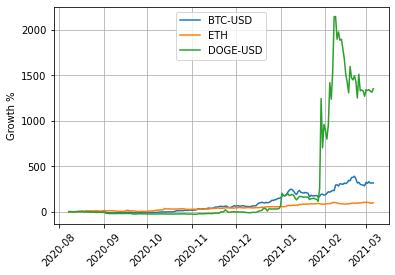

In [14]:
# Display Growth % over time
ax= plt.subplot()
for item in df_norm.columns:
    plt.plot(df_norm[item])

plt.xticks(rotation=45)
ax.legend(df.columns,loc='upper center')
plt.ylabel('Growth %')
ax.grid(True)

## How do the price gains of the listings correlate to each other?

Correlation Matrix

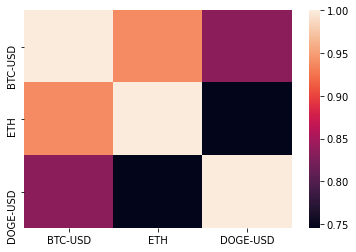

In [15]:
sns.heatmap(df_norm.corr());

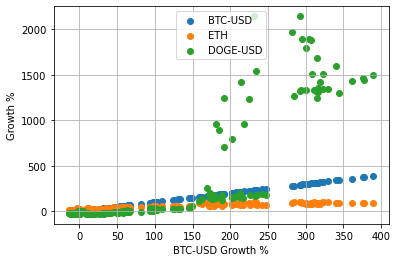

In [16]:
ax= plt.subplot()
for item in df_norm.columns:
    plt.scatter(df_norm.iloc[:,0],df_norm[item])

ax.legend(df_norm.columns,loc='upper center')
plt.xlabel('{} Growth %'.format(df_norm.columns[0]))
plt.ylabel('Growth %')
ax.grid(True)

## Calculate percent and absolute estimate and bounds of Growth 

### Create a linear regression fit for the data with thrice the standard dev. of obs.-est. to determine the boundaries

<b> Linear Regression object, score and price boundaries for each listing </b>

In [17]:
def lin_obj(df):
    df_lin=df.iloc[0:1,:]
    df_lin.reindex(['fit_obj','score','bound'])
    df_lin.drop(index=df_lin.index[0],inplace=True)
    for item in df_lin.columns:
        # ... (intercept and coeff.) of the fits
        X=np.array(pd.to_numeric(df.index)).reshape(-1, 1)
        Y=(df[item].values).reshape(-1, 1)
        lin_list_coeff=[]
        lin_list_intercept=[]
        for i in range(0,1):
            X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0)
            lin_obj=LinearRegression()
            lin_obj.fit(X_train,y_train)
            lin_list_coeff.append(lin_obj.coef_)
            lin_list_intercept.append(lin_obj.intercept_)
        linobj = LinearRegression()
        linobj.coef_=np.array(np.array(lin_list_coeff).mean()).reshape(-1)
        linobj.intercept_=np.array(np.array(lin_list_intercept).mean()).reshape(-1)
        score=linobj.score(X,Y)
        df_lin.loc['fit_obj',item]=linobj
        df_lin.loc['score',item]=score

    # Calculate price bounds
    df_est=pd.DataFrame()
    df_est.rename_axis(index='Datetime')
    df_est['Datetime']=df.index
    df_est.set_index('Datetime',inplace=True)
    for item in df.columns:
        fit_obj=df_lin.loc['fit_obj',item]
        for datetime in df_est.index:
            est=fit_obj.predict(np.array(datetime.value).reshape(-1,1))
            df_est.loc[datetime,'{}'.format(item)]=est
    for item in df.columns:
        df_diff=df[item]-df_est[item]
        bounds=3*df_diff.std()
        df_lin.loc['bound',item]=bounds
        
    return df_lin

Convert rise and fall from % to price (using price change= percent change/100*start price) and display.<br>

In [18]:
# Call lin_obj(...) to create the price estimation object dataframe
df_norm_price_est_obj=lin_obj(df_norm)
df_price_bounds_dict={}
for item in df_norm.columns:
    df_price_bounds_dict[item]=df_norm_price_est_obj.loc['bound',item]*df_start.loc['start_price',item]/100
df_price_bounds=pd.DataFrame(df_price_bounds_dict,index=['price_bounds'])
df_norm_price_est_obj=df_norm_price_est_obj.append(df_price_bounds)
df_norm_price_est_obj

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,BTC-USD,ETH,DOGE-USD
fit_obj,"LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr..."
score,0.827838,0.939647,0.474935
bound,142.661,23.7738,1216.7
price_bounds,16768.4,3.07642,0.0427062


### Estimate the price and bounds vs. date using the fit object

In [19]:
# Function to estimate the price given the price dataframe, fit objects and datetime query
def price_est(df,df_norm_price_est_obj,df_strt,datetime_query):
    df_price_est=pd.DataFrame()
    df_price_est.rename_axis(index='Datetime')
    df_price_est['Datetime']=pd.to_datetime(datetime_query)
    df_price_est.set_index('Datetime',inplace=True)
    for item in df.columns:
        fit_obj=df_norm_price_est_obj.loc['fit_obj',item]
        for datetime in df_price_est.index:
            norm_price_est=fit_obj.predict(np.array(datetime.value).reshape(-1,1))
            price_est=norm_price_est*df_strt.loc['start_price',item]/100+df_strt.loc['start_price',item]
            df_price_est.loc[datetime,'{}'.format(item)]=price_est
            df_price_est.loc[datetime,'{}_low'.format(item)]=price_est-(df_norm_price_est_obj.loc['price_bounds',item])
            df_price_est.loc[datetime,'{}_high'.format(item)]=price_est+(df_norm_price_est_obj.loc['price_bounds',item])
            df_price_est.loc[datetime,'{}_lo_mid'.format(item)]=df_price_est.loc[datetime,['{}'.format(item),
                                                                                         '{}_low'.format(item)]].mean()
            df_price_est.loc[datetime,'{}_hi_mid'.format(item)]=df_price_est.loc[datetime,['{}'.format(item),
                                                                                         '{}_high'.format(item)]].mean()
            df_price_est.loc[datetime,'{}_lo_ratio'.format(item)]=df_price_est.loc[datetime,'{}_low'.format(item)]/price_est
    df_price_est.reindex(df_price_est.index.date)
    df_price_est=df_price_est
    return df_price_est


## What is the predicted share price?

In [20]:
df_price_est=price_est(df_price,df_norm_price_est_obj,df_start,datetime_query)
df_price_est.style.background_gradient(axis=1).format("{:.1f}")

,BTC-USD,BTC-USD_low,BTC-USD_high,BTC-USD_lo_mid,BTC-USD_hi_mid,BTC-USD_lo_ratio,ETH,ETH_low,ETH_high,ETH_lo_mid,ETH_hi_mid,ETH_lo_ratio,DOGE-USD,DOGE-USD_low,DOGE-USD_high,DOGE-USD_lo_mid,DOGE-USD_hi_mid,DOGE-USD_lo_ratio
Datetime,,,,,,,,,,,,,,,,,,
2021-05-28 00:00:00,60572.9,43804.5,77341.4,52188.7,68957.1,0.7,30.9,27.9,34.0,29.4,32.5,0.9,0.1,0.0,0.1,0.0,0.1,0.2


## What kind of volatility do the listings have?

## How do we generate our investment portfolio?

### Estimate the price history along with the bounds and plot the history and estimates for each listing

In [21]:
# Datetime history query values
datetime_query_start_end=pd.date_range(start=start,end=end)

In [22]:
# Generate and display estimates (listing, listing_low, listing_high)
df_price_est_start_end=price_est(df_price,df_norm_price_est_obj,df_start,datetime_query_start_end)
df_price_est_start_end.head().style.format("{:.0f}")

,BTC-USD,BTC-USD_low,BTC-USD_high,BTC-USD_lo_mid,BTC-USD_hi_mid,BTC-USD_lo_ratio,ETH,ETH_low,ETH_high,ETH_lo_mid,ETH_hi_mid,ETH_lo_ratio,DOGE-USD,DOGE-USD_low,DOGE-USD_high,DOGE-USD_lo_mid,DOGE-USD_hi_mid,DOGE-USD_lo_ratio
Datetime,,,,,,,,,,,,,,,,,,
2020-08-08 00:00:00,1753,-15015,18521,-6631,10137,-9,12,8,15,10,13,1,-0,-0,0,-0,0,5
2020-08-09 00:00:00,1954,-14815,18722,-6430,10338,-8,12,9,15,10,13,1,-0,-0,0,-0,0,5
2020-08-10 00:00:00,2155,-14614,18923,-6230,10539,-7,12,9,15,10,13,1,-0,-0,0,-0,0,5
2020-08-11 00:00:00,2355,-14413,19124,-6029,10740,-6,12,9,15,10,13,1,-0,-0,0,-0,0,5
2020-08-12 00:00:00,2556,-14212,19324,-5828,10940,-6,12,9,15,10,13,1,-0,-0,0,-0,0,5


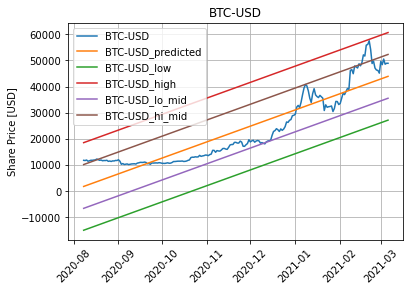

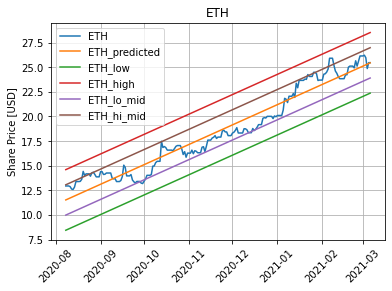

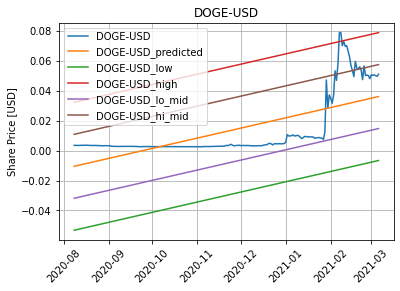

In [23]:
# Plot Open price vs. Time
num_plot=len(df.columns)
i=1
for item in df.columns:
    plt.figure()
    plt.plot(df_price[item])
    plt.plot(df_price_est_start_end[[item,item+'_low',item+'_high',item+'_lo_mid',item+'_hi_mid']])
    plt.legend([item,item+'_predicted',item+'_low',item+'_high',item+'_lo_mid',item+'_hi_mid'])
    plt.ylabel('Share Price [USD]')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.title(item)
    i=i+1

## Constructing the Portfolio

In order to balance the investments, we'd want to have the most benefit (reward) while minimizing volatility (risk).<br>
1. We can consider 'reward' to be the slope of the linear fit to share price (higher the slope, higher the gain).<br>
2. We can consider 'risk' to be the ratio between the price bounds and change in price over the duration of interest <br>
3. Hence we can compute a 'returns ratio' = 'reward'/'risk' for each listing; the higher this value, the more this investment is viable. <br>
4. Then we can compute the sum of the returns ratios for each listing and divide the returns ratio by the summed value, to determine the "weight" of each investment <br>
5. Finally we can multiply the "weight" by the total investment capital (total_investment) to obtain the recommended investment for each listing <br>    

### Use the Linear Regression object to construct the reward, volatility, returns ratio, weight and suggested investment values

In [24]:
# Initialize the portfolio dataframe df_portfolio and update the index suitably
df_portfolio=df_norm_price_est_obj
df_portfolio=df_portfolio.reindex(['reward','risk','returns_ratio','weight','price_bound','suggested_investment'])
df_portfolio=df_portfolio.rename_axis(index='Parameters')

# Update "reward" using the slope of the line fit (multiplied by a suitable factor for display)
for item in (df_portfolio.columns):
    df_portfolio.loc['reward',item]=(df_norm_price_est_obj.loc['fit_obj',item].coef_[0])*10**17
    
# Update the "volatility" as the percent price bound
for item in (df_portfolio.columns):
    df_portfolio.loc['risk',item]=(df_norm_price_est_obj.loc['bound',item])
                                         
# Update the returns ratio as the ratio between the "reward" and "volatility"
for item in (df_portfolio.columns):
    df_portfolio.loc['returns_ratio',item]=(df_portfolio.loc['reward',item]/
                                            df_portfolio.loc['risk',item])
    
# Remove those listings with negative returns_ratio since those imply a falling stock
df_price_est_end=price_est(df,df_norm_price_est_obj,df_start,[df.index[-1].strftime('%m/%d/%y')])
for item in df_portfolio.columns:
    item_low_str=item+'_low'
    item_hi_str=item+'_high'
    if df_portfolio.loc['returns_ratio',item]<=21 or df[item].iloc[-1]<=df_price_est_end[item_low_str].to_numpy()[0]:
        if df_portfolio.loc['reward',item]<=201:
            df_portfolio.pop(item)
        
# Obtain the weighted average of the returns ratio for each listing
for item in (df_portfolio.columns):
    df_portfolio.loc['weight',item]=df_portfolio.loc['returns_ratio',item]/df_portfolio.loc['returns_ratio',:].sum()
    
# Update stop loss limit
for item in (df_portfolio.columns):
    df_portfolio.loc['price_bound',item]=df_norm_price_est_obj.loc['price_bounds',item]
    
# Multiply the weight of each listing by the total investment capital to obtain the recommended investment
for item in (df_portfolio.columns):
    df_portfolio.loc['suggested_investment',item]=df_portfolio.loc['weight',item]*total_investment

    
# Display the portfolio dataframe
df_portfolio.sort_values(axis=1,by='weight',ascending=False).style.background_gradient(axis=1).format("{:.2f}")

,ETH,BTC-USD,DOGE-USD
Parameters,,,
reward,592.76,1976.77,7312.08
risk,23.77,142.66,1216.70
returns_ratio,24.93,13.86,6.01
weight,0.56,0.31,0.13
price_bound,3.08,16768.44,0.04
suggested_investment,1113.66,618.91,268.43


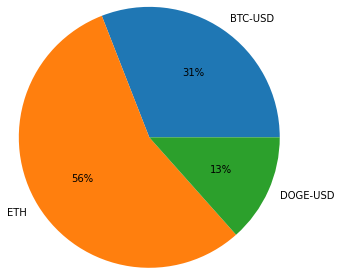

In [25]:
stock_labels=df_portfolio.columns
values=df_portfolio.loc['suggested_investment',:]
plt.pie(values, labels=stock_labels,radius=1.5, autopct='%1.0f%%');

### What kind of volatility do the listings have?

 Refer the "volatility" row, higher the value, greater the volatility

### How do we use the data to construct our portfolio?

Refer the dataframe "df_portfolio"

## Compare with previous

In [26]:
df_saved=pd.read_csv('portfolio.csv')
df_saved.set_index('Parameters',inplace=True)

In [27]:
comm_stocks=list(set(df_saved.columns.tolist()).intersection(set(df_portfolio.columns.tolist())))

Sum: weight_diff    0.0
dtype: float64, Min.: weight_diff   NaN
dtype: float64, Max.: weight_diff   NaN
dtype: float64


IndexError: index 0 is out of bounds for axis 0 with size 0

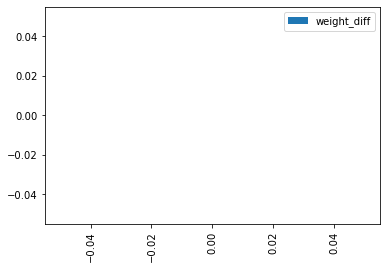

In [28]:
weight_diff={}
for i in range(len(comm_stocks)):
    ticker=comm_stocks[i]
    weight_diff[ticker]=(df_portfolio.loc['weight',
                                          ticker]-df_saved.loc['weight',ticker])/df_portfolio.loc['weight',ticker]*100
df_weight_diff=pd.DataFrame(weight_diff,index=['weight_diff'])
print('Sum: {}, Min.: {}, Max.: {}'.format(df_weight_diff.sum(axis=1),df_weight_diff.min(axis=1),df_weight_diff.max(axis=1)))
df_weight_diff.transpose().plot(kind='bar');

## Lowest Trending

In [ ]:
# Initialize the portfolio dataframe df_portfolio and update the index suitably
df_portfolio=df_norm_price_est_obj
df_portfolio=df_portfolio.reindex(['reward','risk','returns_ratio','weight','price_bound','suggested_investment'])
df_portfolio=df_portfolio.rename_axis(index='Parameters')

# Update "reward" using the slope of the line fit (multiplied by a suitable factor for display)
for item in (df_portfolio.columns):
    df_portfolio.loc['reward',item]=(df_norm_price_est_obj.loc['fit_obj',item].coef_[0])*10**17
    
# Update the "volatility" as the percent price bound
for item in (df_portfolio.columns):
    df_portfolio.loc['risk',item]=(df_norm_price_est_obj.loc['bound',item])
                                         
# Update the returns ratio as the ratio between the "reward" and "volatility"
for item in (df_portfolio.columns):
    df_portfolio.loc['returns_ratio',item]=(df_portfolio.loc['reward',item]/
                                            df_portfolio.loc['risk',item])
    
# Remove those listings with negative returns_ratio since those imply a falling stock
df_price_est_end=price_est(df,df_norm_price_est_obj,df_start,[df.index[-1].strftime('%m/%d/%y')])
for item in df_portfolio.columns:
    item_low_str=item+'_low'
    item_hi_str=item+'_high'
    if df_portfolio.loc['returns_ratio',item]>=-21 or df[item].iloc[-1]>=df_price_est_end[item_hi_str].to_numpy()[0]:
        if df_portfolio.loc['reward',item]>=-201:
            df_portfolio.pop(item)
        
# Obtain the weighted average of the returns ratio for each listing
for item in (df_portfolio.columns):
    df_portfolio.loc['weight',item]=df_portfolio.loc['returns_ratio',item]/df_portfolio.loc['returns_ratio',:].sum()
    
# Update stop loss limit
for item in (df_portfolio.columns):
    df_portfolio.loc['price_bound',item]=df_norm_price_est_obj.loc['price_bounds',item]
    
# Multiply the weight of each listing by the total investment capital to obtain the recommended investment
for item in (df_portfolio.columns):
    df_portfolio.loc['suggested_investment',item]=df_portfolio.loc['weight',item]*total_investment

    
# Display the portfolio dataframe
df_portfolio.sort_values(axis=1,by='weight',ascending=False).style.background_gradient(axis=1).format("{:.2f}")